<a href="https://colab.research.google.com/github/Mmbsaksd/Predicting-Future-Stock-Market-Trends-with-Python-Machine-Learning/blob/main/Predicting_Future_Stock_Market_Trends_with_Python_%26_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Importing thr required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#importing the required model to train
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

#Importing  the finance and date
import datetime
!pip install finta
from finta import TA
!pip install yfinance
import yfinance as yf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
#Definig constant for Data Mining
NUM_DAYS = 1000
INTERVAL = '1d'
symbol = 'SPY'

#Creating the list of symbol for technical indicators
INDICATOR = ['RSI','MACD','STOCH','ADL','ATR','MOM','MFI']

In [4]:
#Pulling the historic data from yfinance
start = (datetime.date.today()- datetime.timedelta(NUM_DAYS))
end = datetime.datetime.today()

data = yf.download(symbol, start = start, end = end, interval = INTERVAL)
data.rename(columns={'Close':'close','High':'high','Low':'low','Volume':'volume','Open':'open','Adj Close':'adj_close'},inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj_close,volume
Date,,,,,,
2020-01-17 00:00:00-05:00,331.700012,332.179993,330.850006,331.950012,317.897278,95846000
2020-01-21 00:00:00-05:00,330.899994,332.179993,330.820007,331.299988,317.274811,77742400
2020-01-22 00:00:00-05:00,332.239990,332.950012,331.170013,331.339996,317.313141,48914900
2020-01-23 00:00:00-05:00,330.630005,332.170013,329.410004,331.720001,317.677063,51963000
2020-01-24 00:00:00-05:00,332.440002,332.529999,327.359985,328.769989,314.851929,87578400


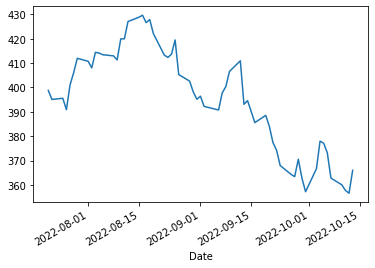

In [5]:
#Ploting temp data
tmp = data.iloc[-60:]
tmp['close'].plot()

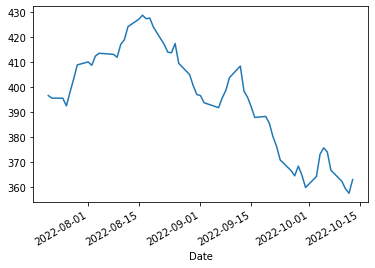

In [6]:
#Definig the function on Feature engineering for technical indicator implimenting
def exponential_smooth(data,alpha):
  return data.ewm(alpha=alpha).mean()

data = exponential_smooth(data,0.65)
temp1 = data.iloc[-60:]
temp1['close'].plot()

In [8]:
#Defining the Function for implimenting the technical indicator

def get_indicator(data):
  for indicator in INDICATOR:
    ind_data = eval('TA.'+indicator+'(data)')
    if not isinstance(ind_data, pd.DataFrame):
      ind_data = ind_data.to_frame()
    data = data.merge(ind_data, left_index=True, right_index=True)
  data.rename(columns={"14 period EMV.":'14 period EMV'},inplace=True)


  #Evaluating the moving average for features
  data['ema50'] = data['close']/data['close'].ewm(50).mean()
  data['ema21'] = data['close']/data['close'].ewm(21).mean()
  data['ema14'] = data['close']/data['close'].ewm(14).mean()
  data['ema5'] = data['close']/data['close'].ewm(5).mean()

  #Normalization of volume
  data['normVol'] = data['volume']/data['volume'].ewm(5).mean()

  #Remove columns that wont be used as features
  del (data['open'])
  del (data['adj_close'])
  del (data['high'])
  del (data['low'])
  del (data['volume'])

  return data

data = get_indicator(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ema50', 'ema21', 'ema14',
       'ema5', 'normVol'],
      dtype='object')


In [10]:
data.tail()

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ema50,ema21,ema14,ema5,normVol
Date,,,,,,,,,,,,,,
2022-10-07 00:00:00-04:00,366.741701,36.595540,-8.338900,-8.942747,27.881483,3.487822e+09,8.560137,-4.141759,34.828416,0.920850,0.947544,0.959765,0.986415,0.993520
2022-10-10 00:00:00-04:00,362.372588,33.850052,-8.517195,-8.857637,13.437246,3.452290e+09,8.667960,-4.238121,34.805675,0.911490,0.938976,0.951609,0.978797,0.860986
2022-10-11 00:00:00-04:00,359.361400,32.064606,-8.800032,-8.846116,8.617879,3.413168e+09,8.520566,-5.149352,35.121410,0.905622,0.934096,0.947257,0.975433,0.927122
2022-10-12 00:00:00-04:00,357.540488,30.999774,-9.066600,-8.890213,4.197324,3.361907e+09,8.406765,-10.882774,35.498703,0.902785,0.932356,0.946086,0.975287,0.864592
2022-10-13 00:00:00-04:00,363.019672,37.703703,-8.735040,-8.859178,43.714005,3.442333e+09,8.800657,-1.741976,43.672857,0.918121,0.948946,0.963115,0.991847,1.227149


In [13]:
#Definig the function for creating truth value columns
def predict_value(data, window):

  prediction = (data.shift(-window)['close']>=data['close'])
  prediction = prediction.iloc[:-window]
  data['pred'] = prediction.astype(int)

  return data

data = predict_value(data, window=15)
del (data['close'])
data = data.dropna()
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ema50,ema21,ema14,ema5,normVol,pred
Date,,,,,,,,,,,,,,
2022-09-16 00:00:00-04:00,35.227620,-4.064334,-2.458701,11.351919,3.610952e+09,7.418190,-8.779728,26.061922,0.951861,0.962294,0.963550,0.975339,1.141163,0.0
2022-09-19 00:00:00-04:00,35.804989,-4.551135,-2.877188,19.721767,3.671645e+09,7.344292,-5.471407,25.931302,0.953824,0.964995,0.966925,0.980297,0.961225,0.0
2022-09-20 00:00:00-04:00,33.787276,-5.099608,-3.321672,13.432613,3.703006e+09,7.253363,-6.250501,26.051816,0.948066,0.959999,0.962652,0.977708,0.937239,0.0
2022-09-21 00:00:00-04:00,30.233687,-5.895243,-3.836386,4.269369,3.632190e+09,7.458671,-15.441165,25.714764,0.936189,0.949061,0.952595,0.970012,1.123657,0.0
2022-09-22 00:00:00-04:00,27.902469,-6.764206,-4.421950,2.830320,3.567225e+09,7.443243,-22.408410,25.511232,0.927872,0.941874,0.946383,0.966451,1.055179,0.0
